In [24]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [177]:
# Set some parameters
im_width = 512
im_height = 512
border = 5

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [154]:
images = "/content/drive/MyDrive/data/train_images"
ids = next(os.walk(images))[2] # list of names all images in the given path
print("No. of images = ", len(ids))


No. of images =  30


In [155]:
print(ids)
print(len(ids))

['DepthViewer_Right_10028356_1080_21-07-2020-14-31-46.jpg', 'DepthViewer_Left_10028356_1080_21-07-2020-14-33-16.jpg', 'DepthViewer_Left_10028356_1080_21-07-2020-14-37-02.jpg', 'DepthViewer_Left_10028356_1080_21-07-2020-14-35-28.jpg', 'DepthViewer_Left_10028356_1080_21-07-2020-14-34-37.jpg', 'DepthViewer_Left_10028356_1080_21-07-2020-14-32-41.jpg', 'DepthViewer_Left_10028356_1080_21-07-2020-14-31-38.jpg', 'DepthViewer_Left_10028356_1080_21-07-2020-14-30-47.jpg', 'DepthViewer_Left_10028356_1080_21-07-2020-14-29-13.jpg', 'DepthViewer_Left_10028356_1080_21-07-2020-14-29-48.jpg', 'DepthViewer_Left_10028356_1080_21-07-2020-14-28-02.jpg', 'DepthViewer_Right_10028356_1080_21-07-2020-14-33-22.jpg', 'DepthViewer_Right_10028356_1080_21-07-2020-14-32-34.jpg', 'DepthViewer_Right_10028356_1080_21-07-2020-14-34-30.jpg', 'DepthViewer_Right_10028356_1080_21-07-2020-14-35-37.jpg', 'DepthViewer_Right_10028356_1080_21-07-2020-14-38-31.jpg', 'DepthViewer_Right_10028356_1080_21-07-2020-14-42-23.jpg', 'Depth

In [156]:
#Resize all the images to the width and height specified and save it in the destination folder
from PIL import Image
import os, sys

width = 512
height = 512
dim = (width, height)
train_im = '/content/drive/MyDrive/data/train_images/'
resized_train_im = '/content/drive/MyDrive/data/resized_train_images/'
train_masks = '/content/drive/MyDrive/data/train_masks/'
resized_train_masks='/content/drive/MyDrive/data/resized_train_masks/'
def resize_images(path,dest):

  dirs = os.listdir( path )
# create new folder if the destination folder is not present
  if not os.path.exists(dest):
      os.makedirs(dest)

  for item in dirs:
    if os.path.isfile(path+item):
      im = Image.open(path+item)
      f, e = os.path.splitext(path+item)
    # resize image
      imResize = im.resize((width,height), Image.ANTIALIAS)
    # save image to destination folder
      imResize.save('{}{}{}'.format(dest,'/',os.path.split(item)[1]))

resize_images(train_im,resized_train_im)
resize_images(train_masks,resized_train_masks)







In [178]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

#### Load the images and masks into arrays

In [181]:

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    print(id_)
    img = load_img(resized_train_im+"/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (512,512, 1), mode = 'constant', preserve_range = True)
    
    # Load masks
    mask = img_to_array(load_img(resized_train_masks+"/"+id_, grayscale=True))
    mask = resize(mask, (512,512, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


DepthViewer_Right_10028356_1080_21-07-2020-14-31-46.jpg
DepthViewer_Left_10028356_1080_21-07-2020-14-33-16.jpg
DepthViewer_Left_10028356_1080_21-07-2020-14-37-02.jpg
DepthViewer_Left_10028356_1080_21-07-2020-14-35-28.jpg
DepthViewer_Left_10028356_1080_21-07-2020-14-34-37.jpg
DepthViewer_Left_10028356_1080_21-07-2020-14-32-41.jpg
DepthViewer_Left_10028356_1080_21-07-2020-14-31-38.jpg
DepthViewer_Left_10028356_1080_21-07-2020-14-30-47.jpg
DepthViewer_Left_10028356_1080_21-07-2020-14-29-13.jpg
DepthViewer_Left_10028356_1080_21-07-2020-14-29-48.jpg
DepthViewer_Left_10028356_1080_21-07-2020-14-28-02.jpg
DepthViewer_Right_10028356_1080_21-07-2020-14-33-22.jpg
DepthViewer_Right_10028356_1080_21-07-2020-14-32-34.jpg
DepthViewer_Right_10028356_1080_21-07-2020-14-34-30.jpg
DepthViewer_Right_10028356_1080_21-07-2020-14-35-37.jpg
DepthViewer_Right_10028356_1080_21-07-2020-14-38-31.jpg
DepthViewer_Right_10028356_1080_21-07-2020-14-42-23.jpg
DepthViewer_Right_10028356_1080_21-07-2020-14-40-19.jpg
De

In [182]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

#### Below code can be used to visualize the images and corresponding masks

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: No contour levels were found within the data range.
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'grayscale')

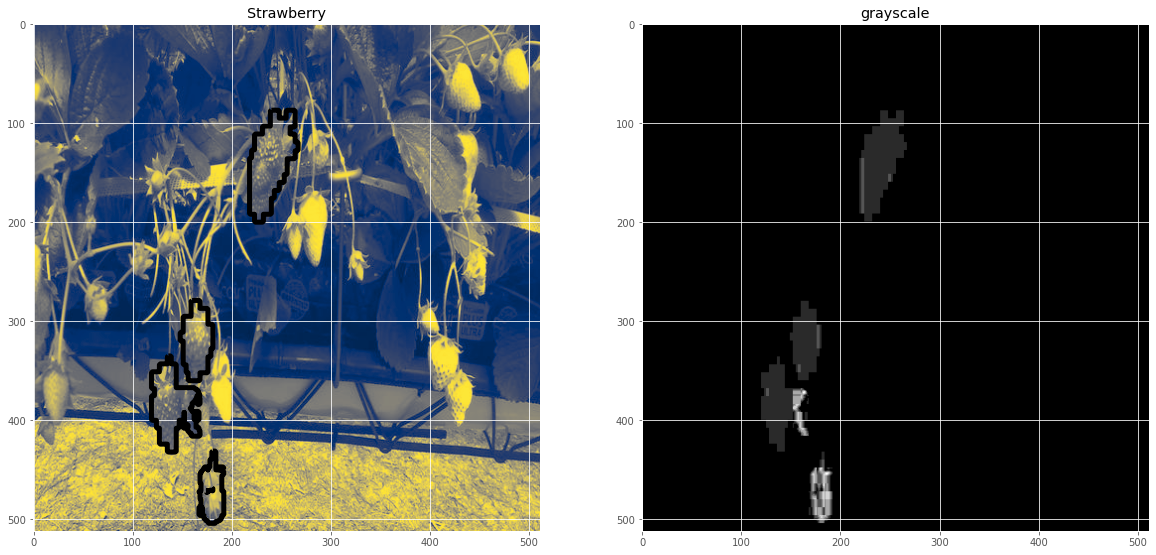

In [183]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0],cmap = 'cividis',  interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating ripe strawberry and unripe ones
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Strawberry')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('grayscale')


In [315]:
train_images = x_img


from tensorflow.keras.utils import normalize     
#Convert list to array for machine learning processing          
train_masks = mask

###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

#################################################
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [319]:

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda




################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [320]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training

from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(X, y, test_size = 0.10, random_state = 0)
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 
n_classes=4
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))



###############################################################
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_masks_reshaped_encoded),
                                                 train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=10, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
                    


model.save('test.hdf5')
#model.save('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')
############################################################

 


Class values in the dataset are ...  [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098]
Class weights are...: [1.46349742e-01 7.92071549e+00 1.50398164e+02 2.24246364e+02
 3.76373295e+01 3.40446753e+02 5.34987755e+03]
Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_645 (Conv2D)             (None, 512, 512, 16) 160         input_7[0][0]                    
__________________________________________________________________________________________________
dropout_278 (Dropout)           (None, 512, 512, 16) 0           conv2d_645[0][0]                 
_______________________________

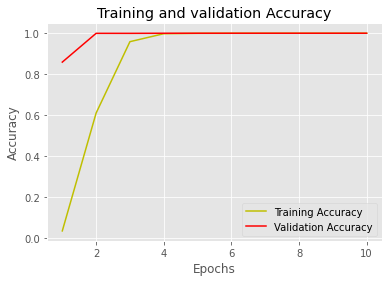

In [324]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




Mean IoU = 1.0
[[786432.      0.      0.      0.]
 [     0.      0.      0.      0.]
 [     0.      0.      0.      0.]
 [     0.      0.      0.      0.]]
IoU for class1 is:  1.0
IoU for class2 is:  nan
IoU for class3 is:  nan
IoU for class4 is:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in float_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in float_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in float_scalars


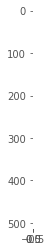

In [325]:
##################################
#model = get_model()
model.load_weights('test.hdf5')  
#model.load_weights('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5') #IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

In [327]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [328]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(4, (1, 1), activation='relu')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [329]:
input_img = Input((im_height, im_width, 3), name='img')


model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [330]:
model.summary()

Model: "model_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_665 (Conv2D)             (None, 512, 512, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_505 (BatchN (None, 512, 512, 16) 64          conv2d_665[0][0]                 
__________________________________________________________________________________________________
activation_505 (Activation)     (None, 512, 512, 16) 0           batch_normalization_505[0][0]    
___________________________________________________________________________________________

In [331]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [333]:
#input_img=input_img.reshape(4, 512, 512, 3)

results = model.fit(X_train, y_train, batch_size=4, epochs=15, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/15


ValueError: ignored

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### Inference

In [129]:
# load the best model
model.load_weights('model-tgs.h5')

In [130]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 1s 1s/step - loss: 0.8703 - accuracy: 0.2666


[0.8702563643455505, 0.26655706763267517]

In [131]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

1/1 [==============================] - 1s 998ms/step


In [132]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [133]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Strawberry')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Strawberry Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('strawberry');

### Predictions on training set

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: No contour levels were found within the data range.


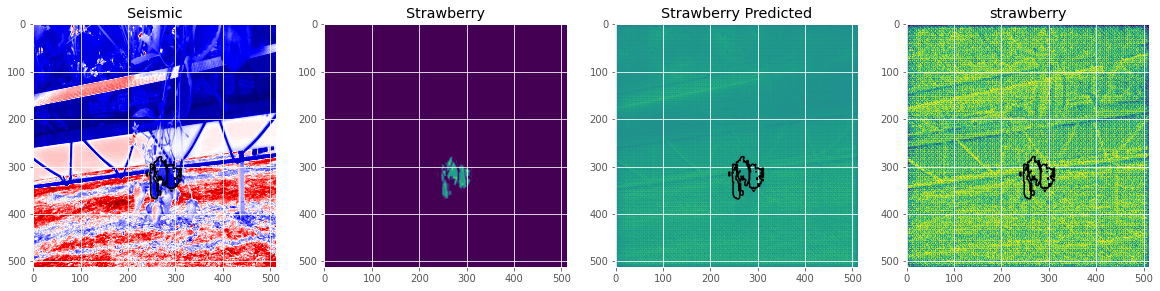

In [138]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: No contour levels were found within the data range.


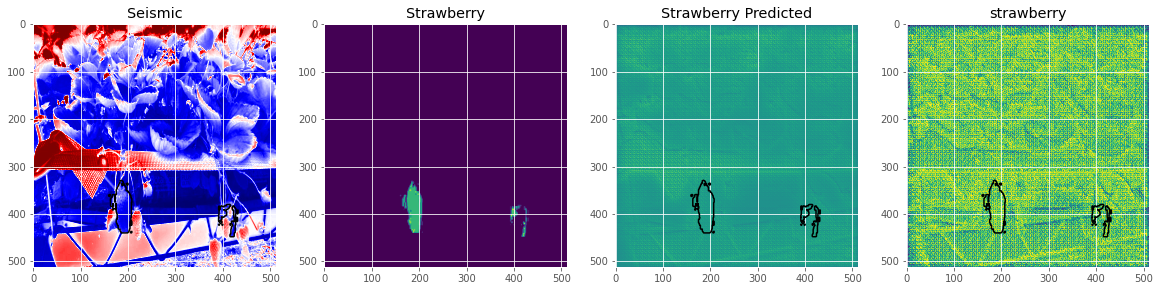

In [139]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: No contour levels were found within the data range.


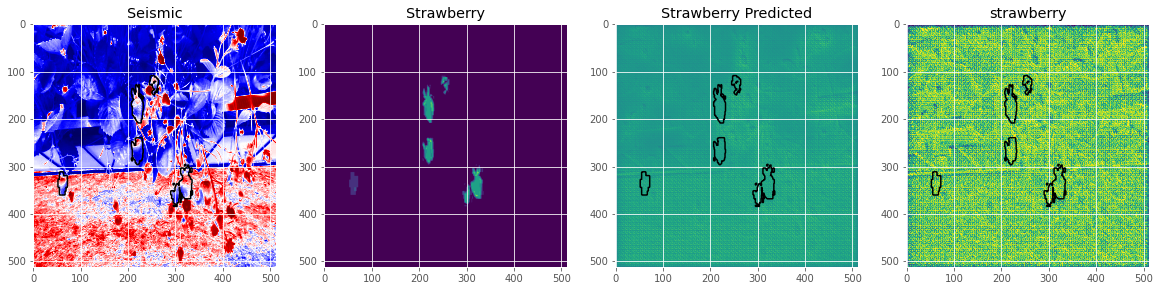

In [140]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: No contour levels were found within the data range.


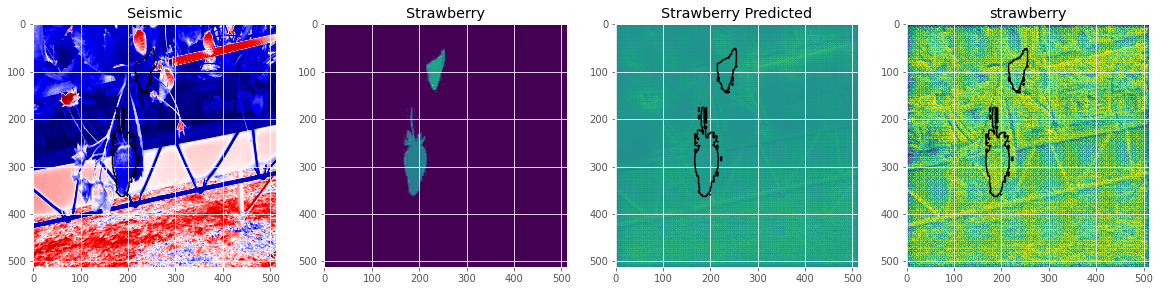

In [137]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

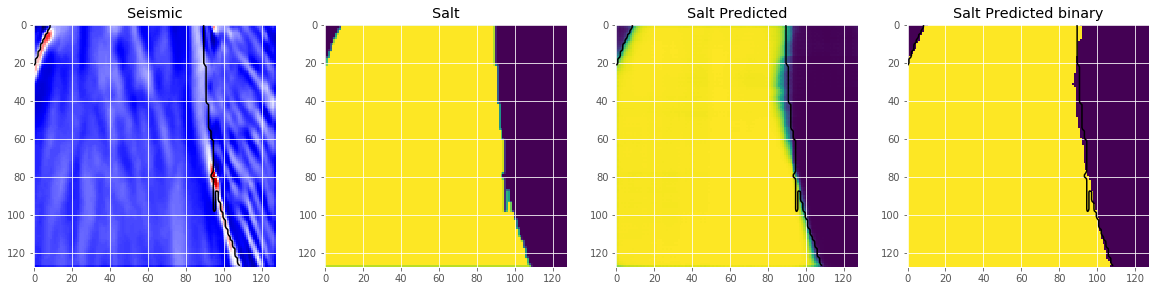

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

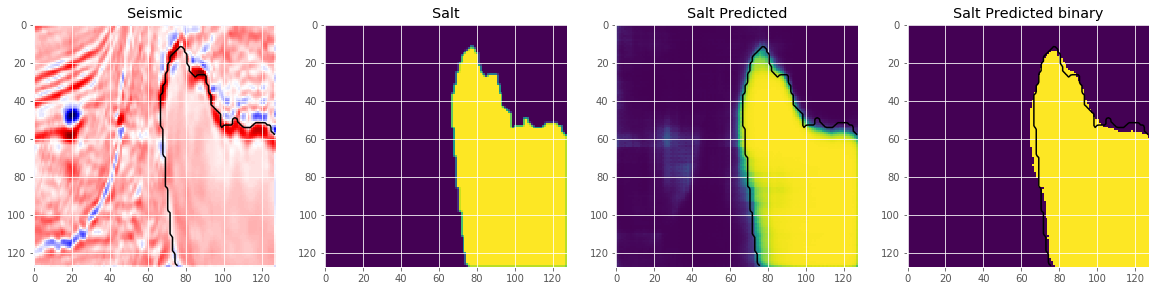

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

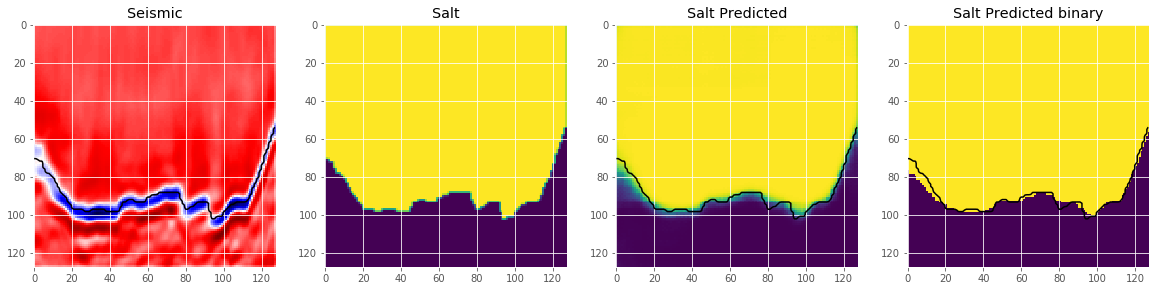

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

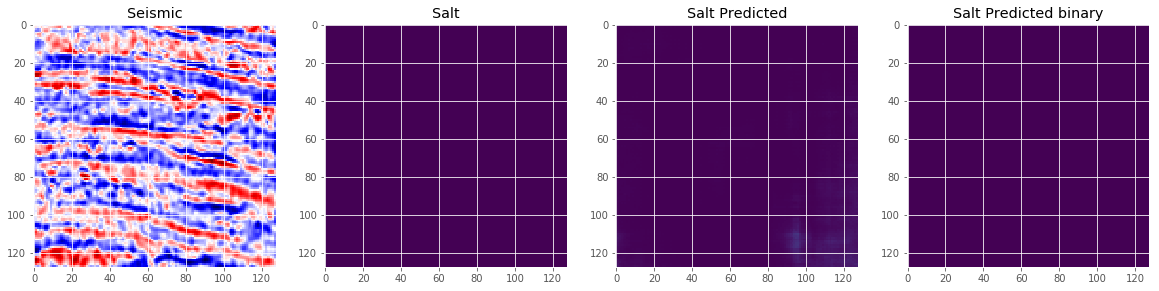

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

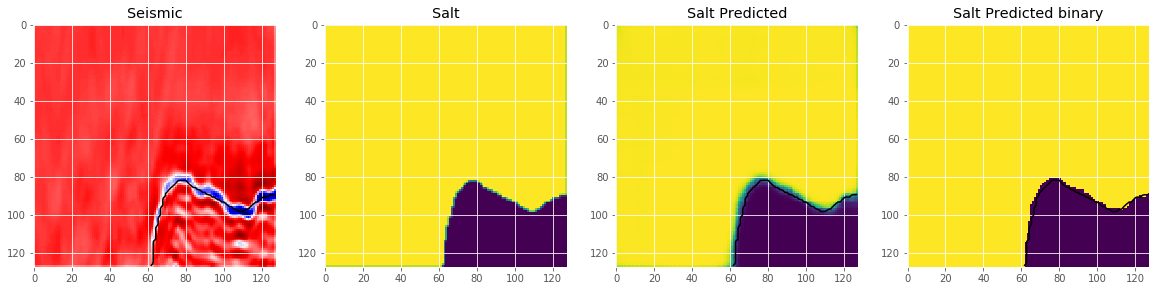

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

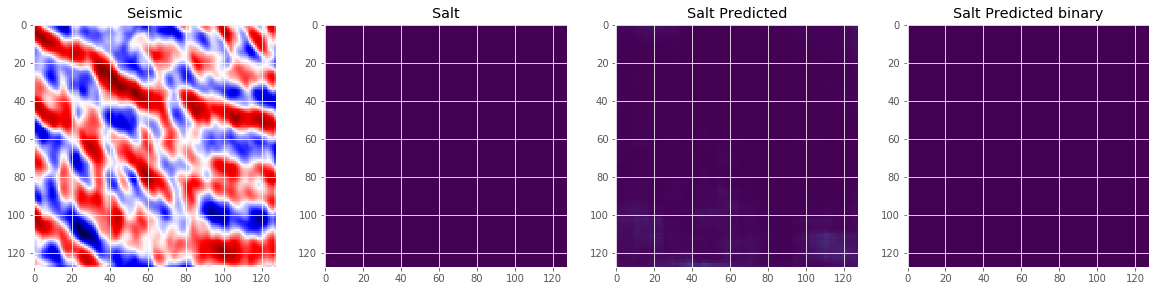

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

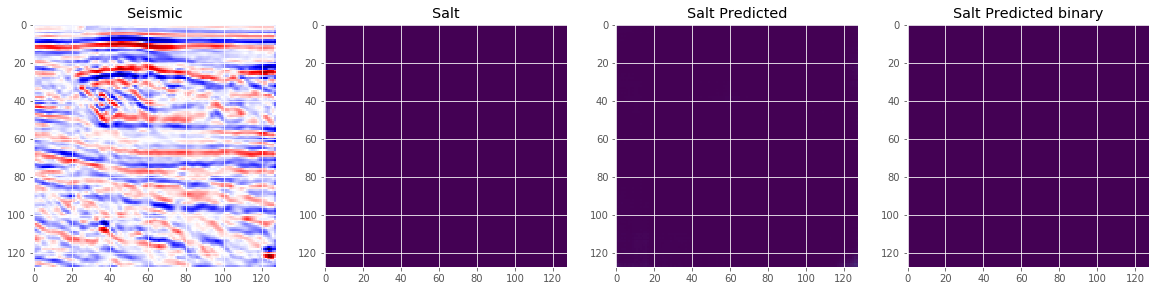

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

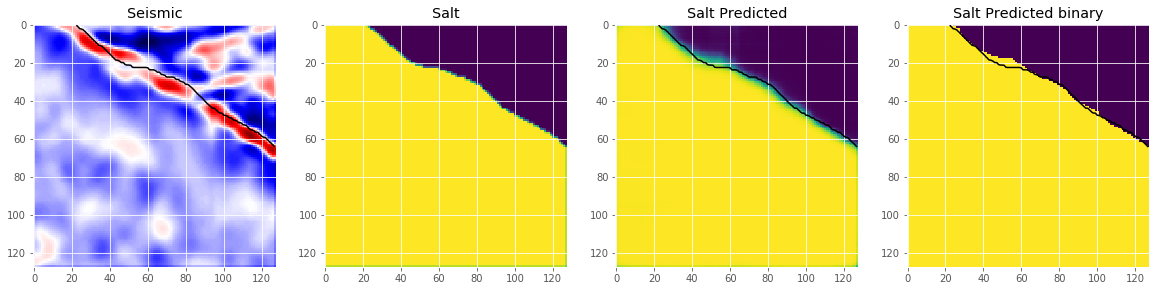

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

### Predictions on test set

In [ ]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

IndexError: ignored

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

IndexError: ignored

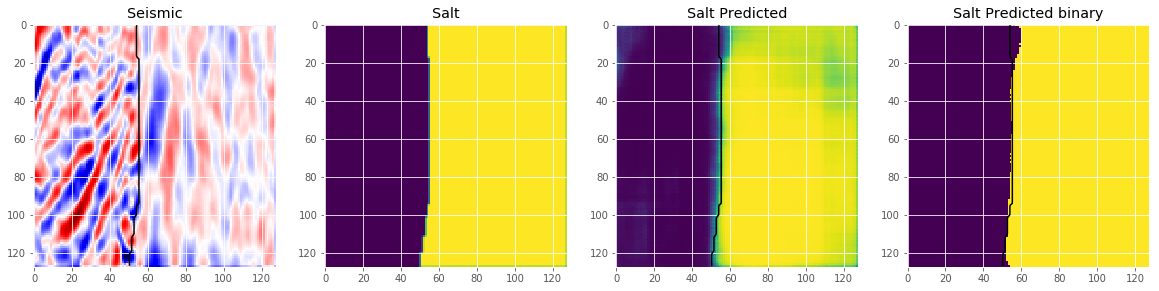

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

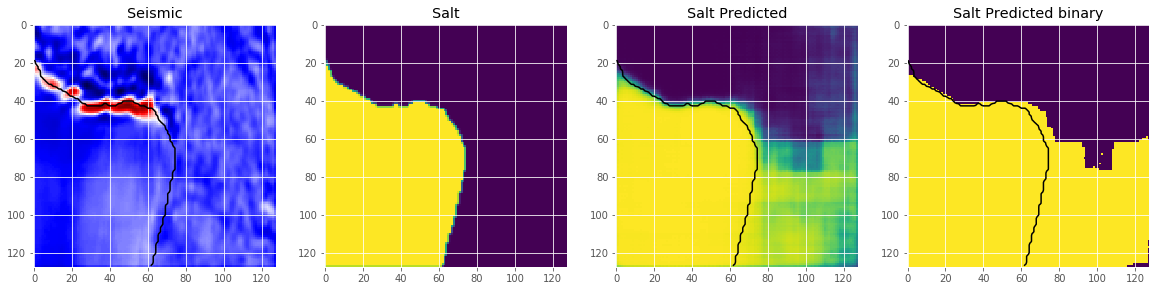

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

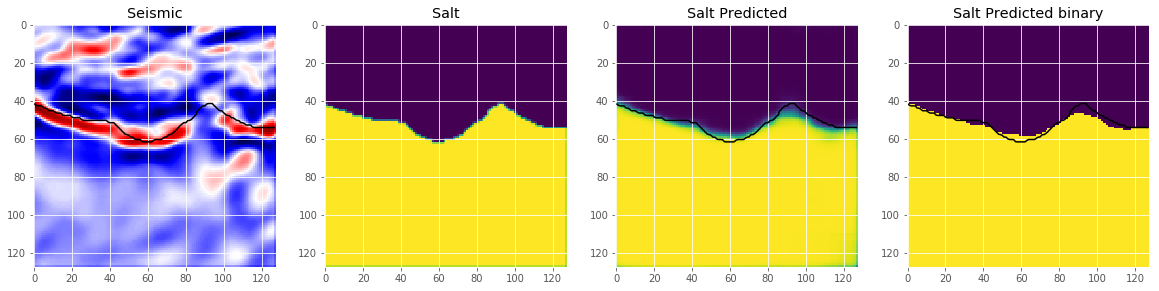

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

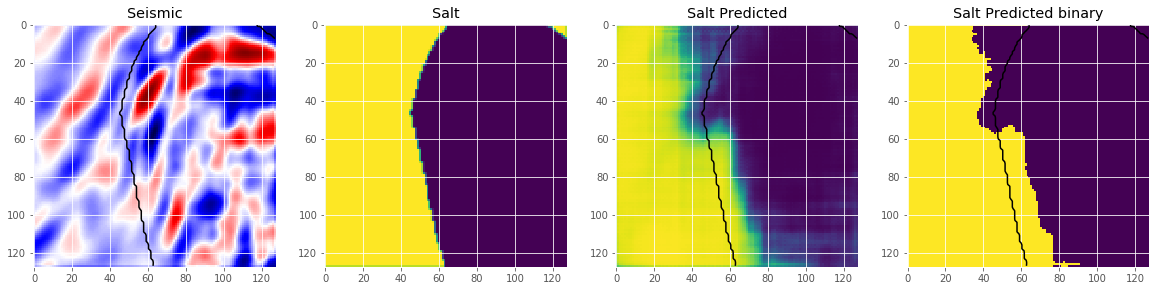

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

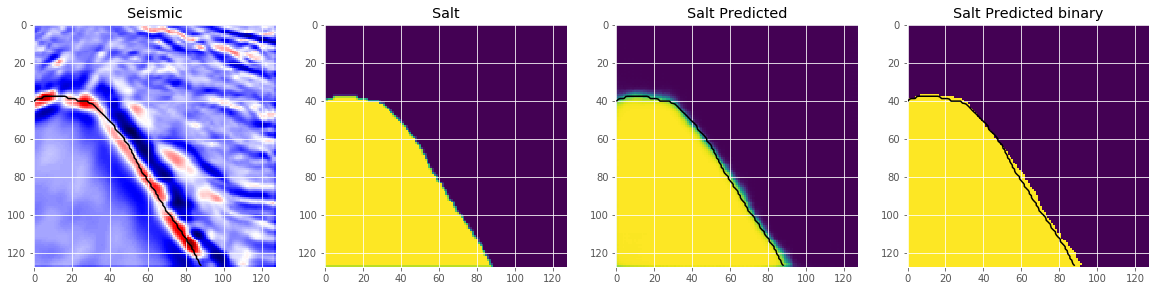

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

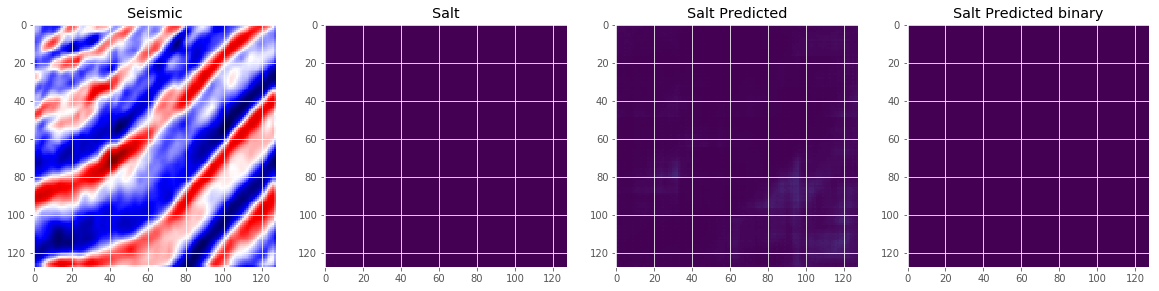

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

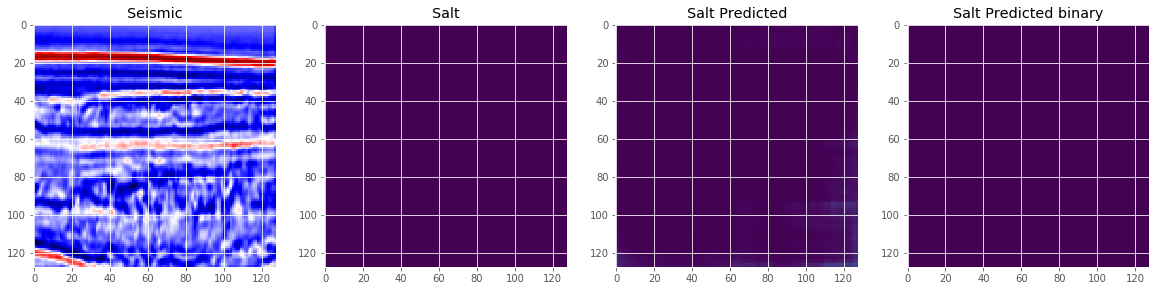

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

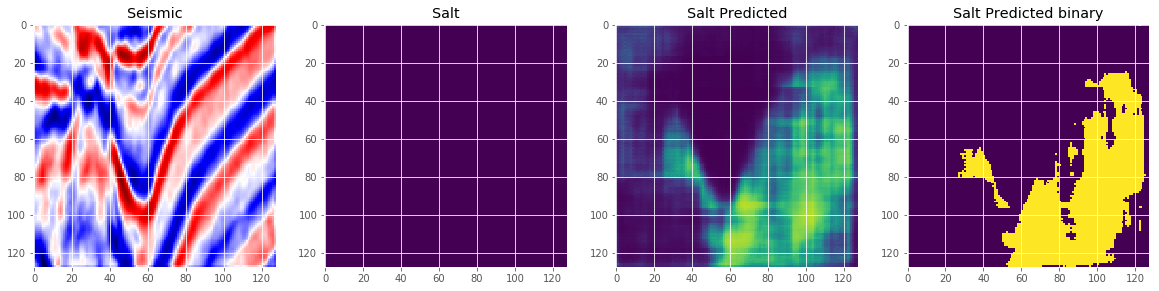

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

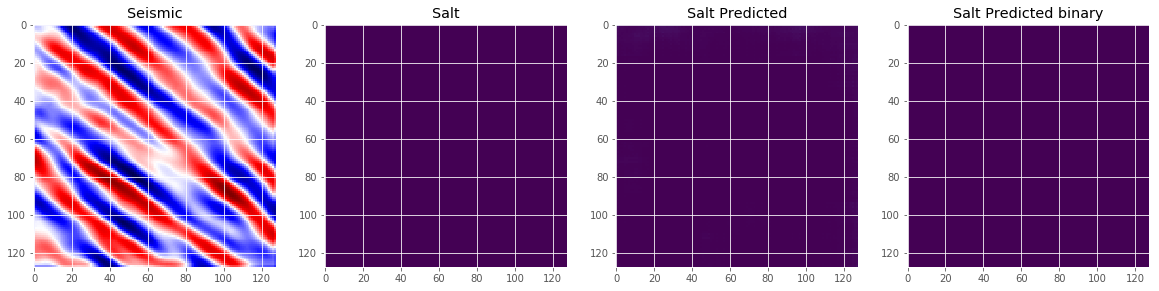

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

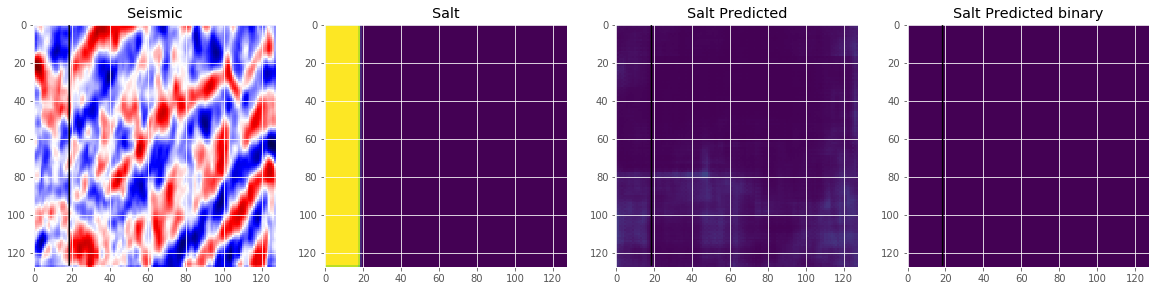

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

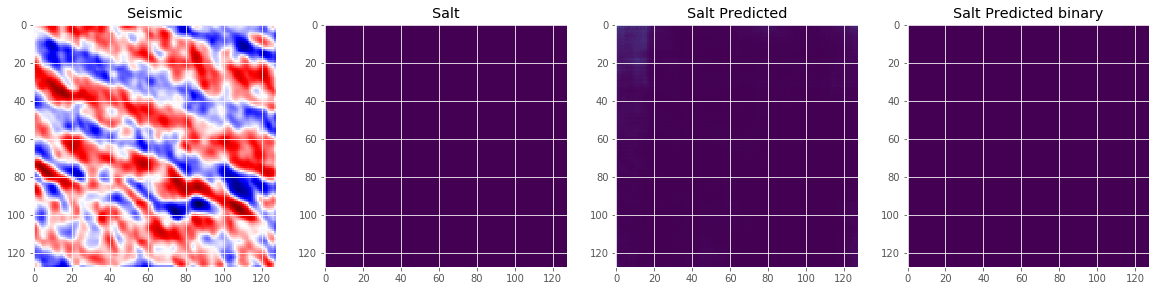

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

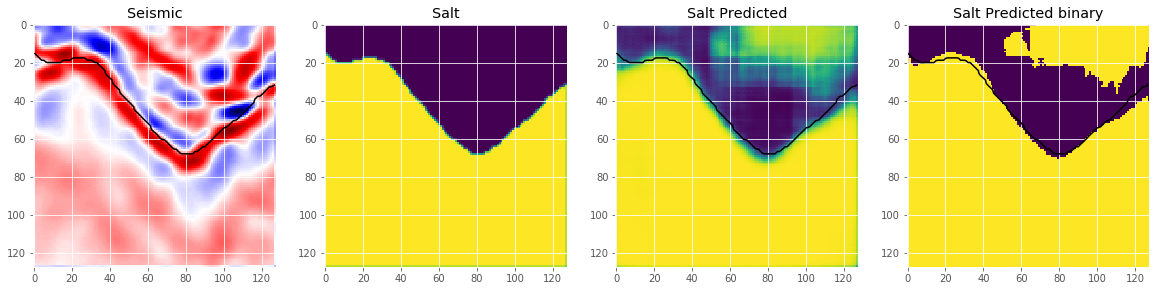

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

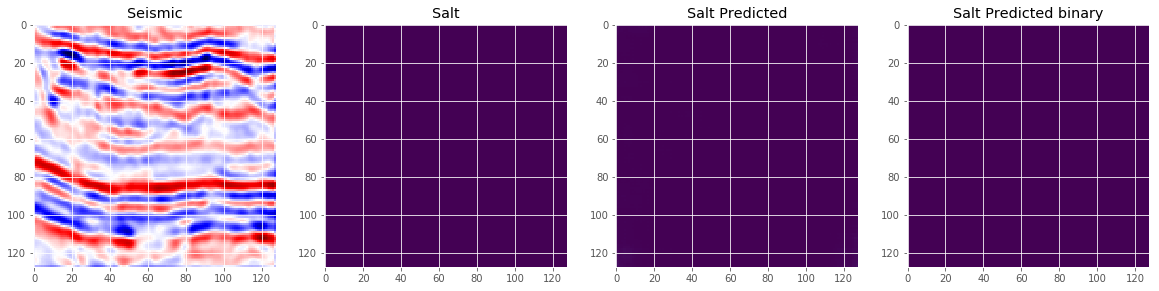

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

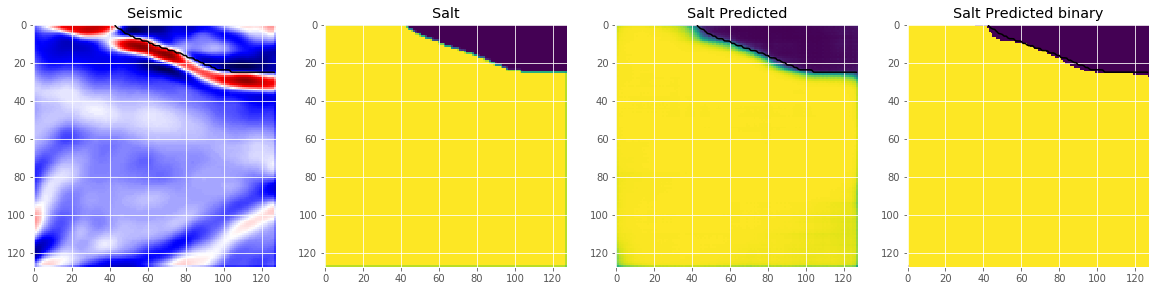

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)